# Instructions

1. First create your python environment using Anaconda or Virtualenv with `python>=3.10`.
2. Install prerequisites: `pip install torch numpy matplotlib PyYAML`.
3. Install auxilary package "comblearn" on the project root: `python setup.py develop`.
4. Run "Initialization" part of the notebook.
5. For the first experiment (Learning Coverage Function) run Part 1 of the notebook.
6. For the second experiment (Maximizing Social Welfare) run Part 2 of the notebook.
7. For each experiment use the trial config to generate desired output.

## Initialization

In [1]:
import torch
import torch.nn as nn
import logging

from comblearn.env import CombinatorialAuction

logging.basicConfig(level=20)

In [2]:
vf_configs = ['edsf', 'dsf', 'dpst', 'strf']

## 1. Learning Coverage and Cut Functions

### Trial Config

In [6]:
# Try different configs to get the desired ouputs

config = {
    'prob': 'low', # ['low', 'mid', 'high'],
    'function': 'dsf', # ['dsf', 'edsf', 'egdsf', 'dpst', 'strf']
    'true': 'cut' # ['coverage', 'cut']
}

In [7]:
import yaml 

if config['true'] == 'coverage':
    with open("config_coverage.yaml") as fp:
        cfg = yaml.load(fp, Loader=yaml.FullLoader)
else:
    with open("config_cut.yaml") as fp:
        cfg = yaml.load(fp, Loader=yaml.FullLoader) 

In [8]:
auction = CombinatorialAuction(cfg['auction'])

In [9]:
if config['prob'] == 'low':
    X, y = auction.data_handler.R['0']
    vfa = auction.bidders[0].vf
elif config['prob'] == 'mid':
    X, y = auction.data_handler.R['1']
    vfa = auction.bidders[1].vf
else:
    X, y = auction.data_handler.R['2']
    vfa = auction.bidders[2].vf
items = auction.items

In [10]:
n = X.shape[0]
tr = int(80/100 * n)
X_train = X[0: tr]
y_train = y[0: tr] 
X_test = X[tr:]
y_test = y[tr:] 

In [11]:
y[:10]

tensor([502, 360, 436, 292, 206, 512, 488, 258, 452,  46], device='cuda:0')

In [12]:
from comblearn.data import ExtendedDSFValueFunction, ExtendedGeneralDSFValueFunction
from comblearn.data import DSFValueFunction, DeepSets, SetTransformer

if config['function'] == 'edsf':
    vf = ExtendedDSFValueFunction(items, 60, [64, 64, 64, 64], 95).to("cuda")
elif config['function'] == 'egdsf':
    vf = ExtendedGeneralDSFValueFunction(items, 60, [64, 64, 64, 64, 10], 95).to("cuda")
elif config['function'] == 'dpst':
    vf = DeepSets(items, [64, 64, 64], [64, 64, 64]).to('cuda')
elif config['function'] == 'strf':
    vf = SetTransformer(items, 1, 1, dim_hidden=128).to("cuda")
else:
    vf = DSFValueFunction(items, 60, [64, 64, 64], 95).to("cuda")

In [13]:
# In order to check the output before training

i = 10
vf(X[1]), y[i]

(tensor([221.3803], device='cuda:0', grad_fn=<SqueezeBackward3>),
 tensor(512, device='cuda:0'))

In [14]:
from torch.optim import Adam

optimizer = Adam(vf.parameters(), lr=0.01)
criterion = nn.L1Loss()

losses = []

for _ in range(4000):
    optimizer.zero_grad()
    yp = vf(X_train)
    loss = criterion(yp, y_train)
    loss.backward(retain_graph=True)
    losses.append(loss.item())
    optimizer.step()
    with torch.no_grad():
        vf.relu()
    print(loss)

/home/mohammad_hosseini/anaconda3/envs/auction/lib/python3.10/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([819])) that is different to the input size (torch.Size([819, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


tensor(186.1641, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(166.7992, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(159.0865, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(148.1577, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(141.1256, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(138.4621, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(137.0854, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(135.8554, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(133.6889, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(131.2417, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(129.5081, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(128.5352, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(128.4889, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(128.6114, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(127.8875, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(126.7696, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(126.0050, device='cuda:0', grad_fn=<MeanBackward0

In [15]:
# To chek the loss on test set

yp = vf(X_test)
criterion(yp, y_test).cpu().detach().numpy()

/home/mohammad_hosseini/anaconda3/envs/auction/lib/python3.10/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([205])) that is different to the input size (torch.Size([205, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


array(133.3767, dtype=float32)

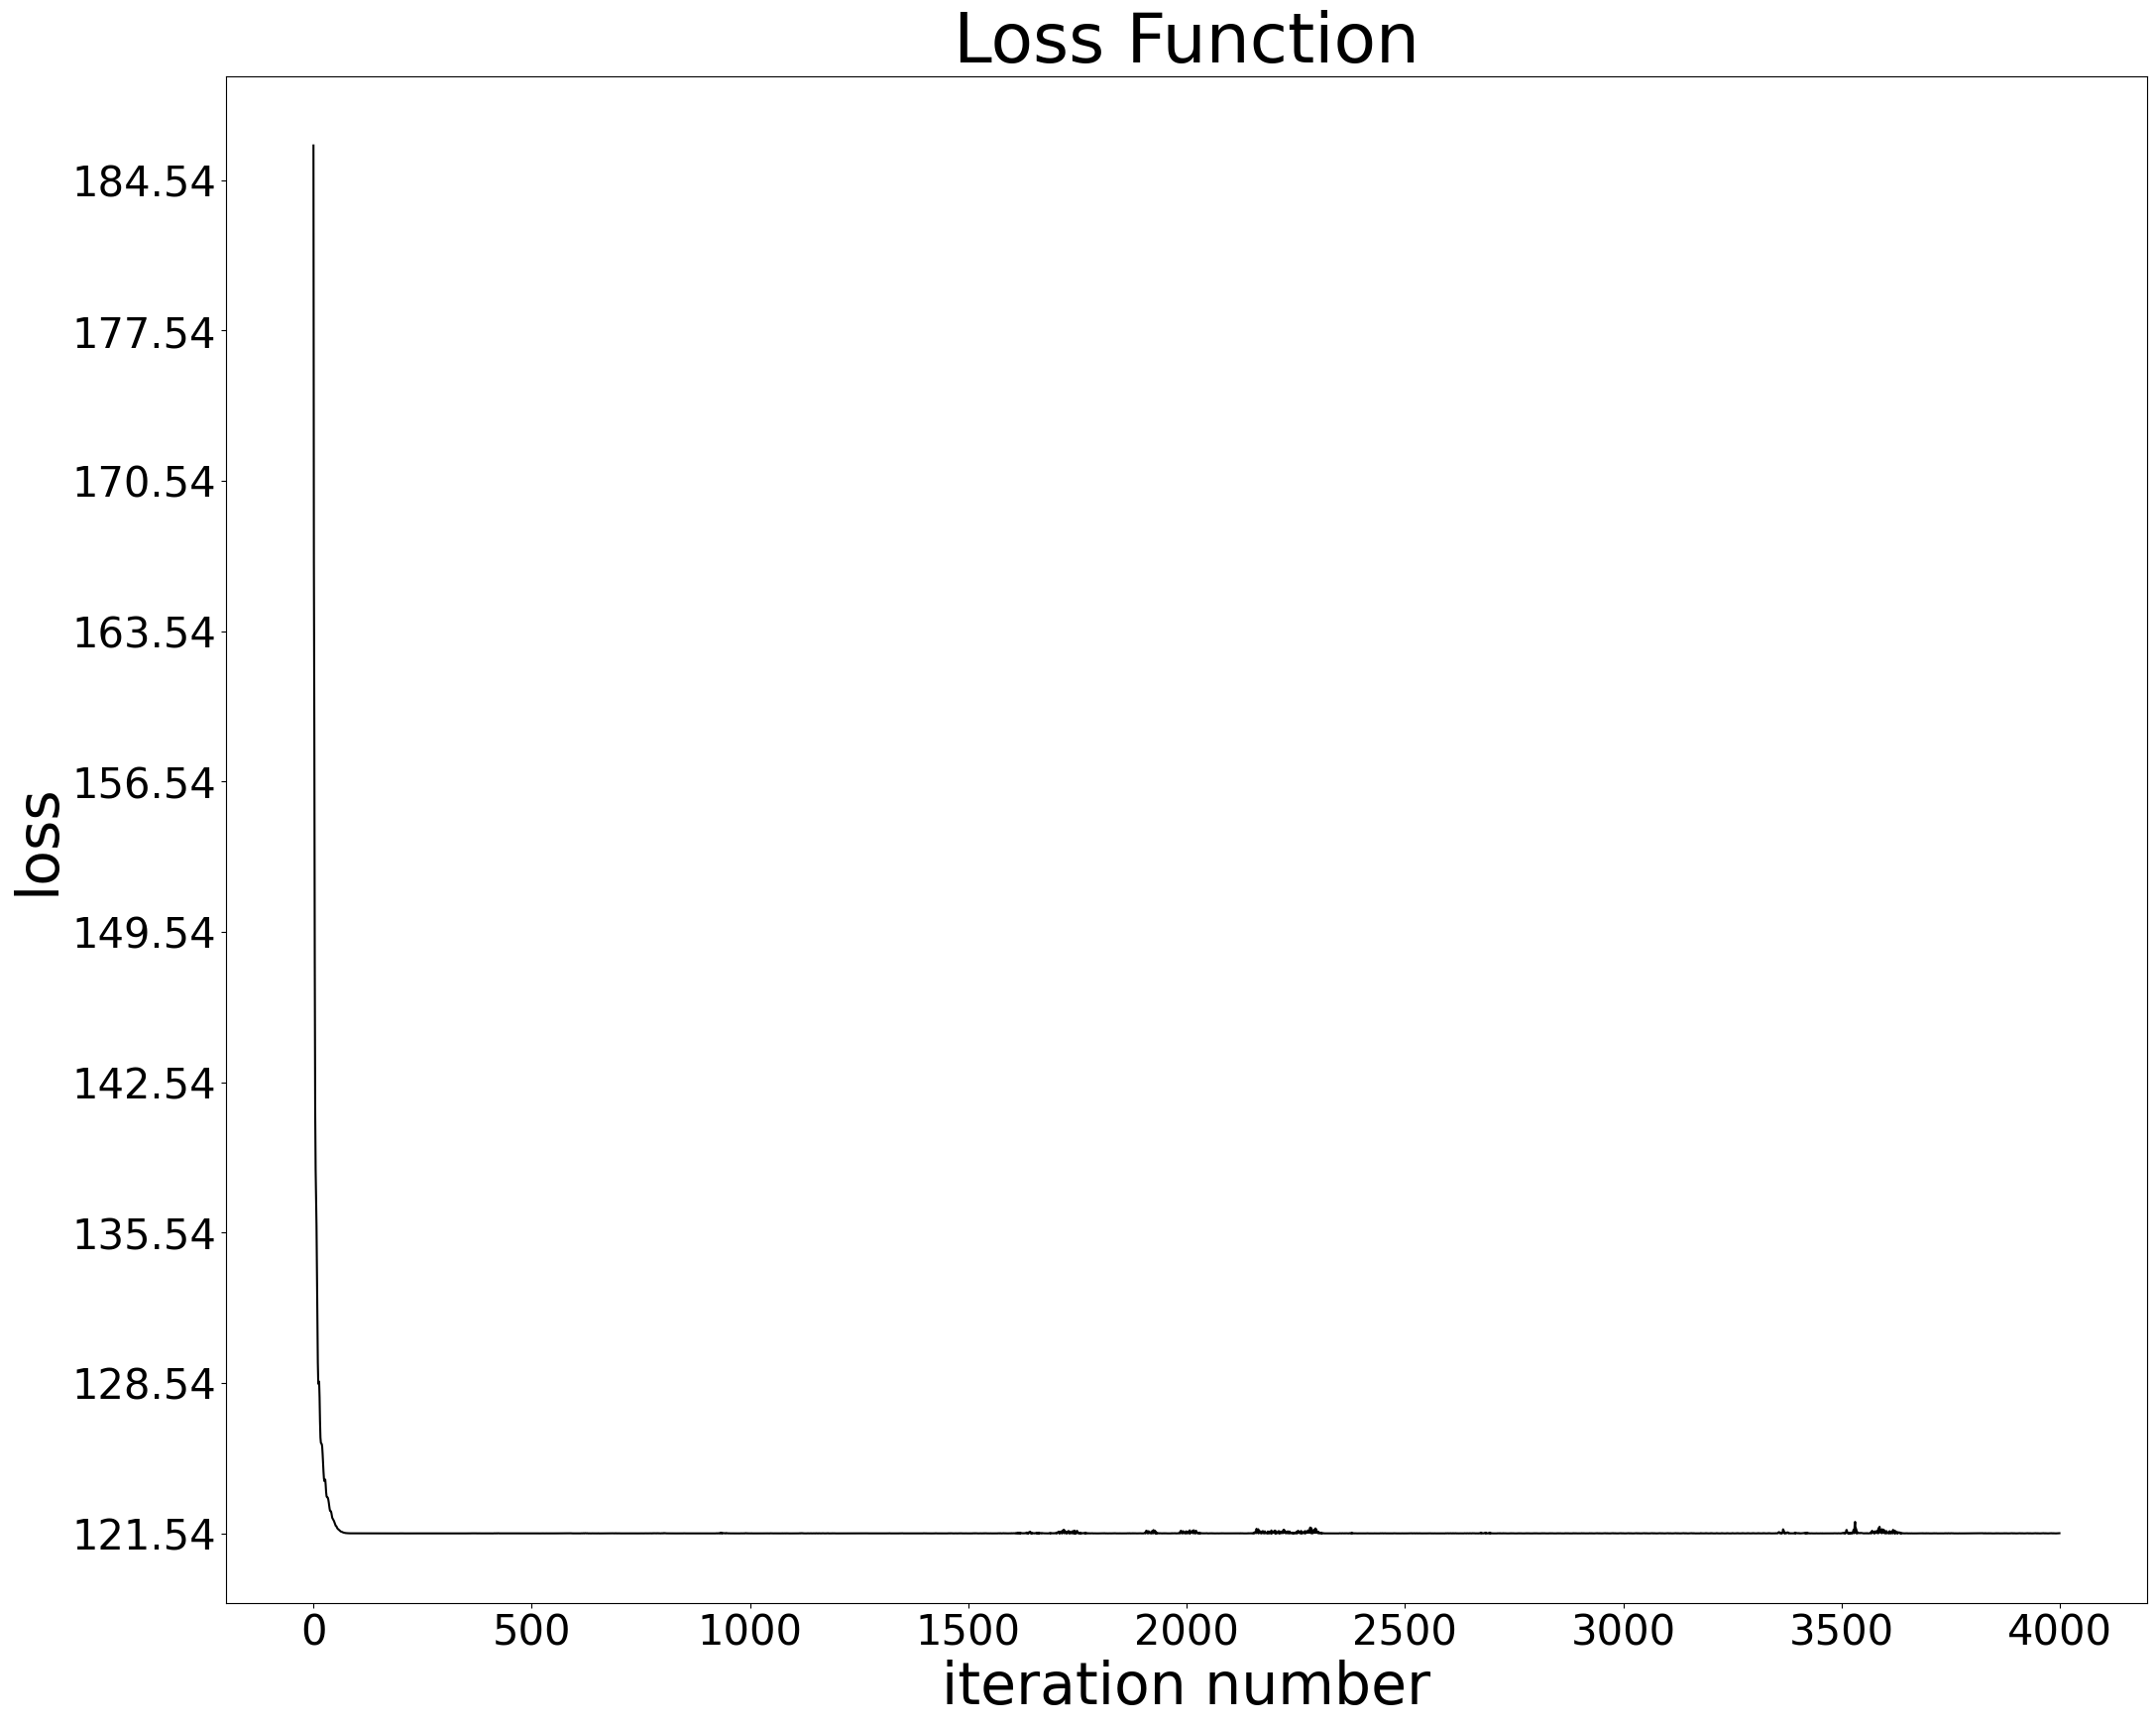

In [16]:
# To plot the loss throughout the iterations

import matplotlib.pyplot as plt
import numpy as np

x = np.arange(len(losses))
plt.figure(figsize=(25, 20))
plt.title('Loss Function', fontdict={'size': 50})
plt.xlabel('iteration number', fontdict={'size': 42})
plt.ylabel('loss', fontdict={'size': 42})
plt.yticks(np.arange(min(losses), max(losses), (max(losses) - min(losses))//10 + 1), fontsize=30)
plt.xticks(fontsize=30)
plt.plot(x, losses, label='coverage_function', color='black')
plt.savefig("loss.pdf")
plt.show()

In [15]:
# In order to check the output after training

i = 10
vf(X[i]), y[i]

(tensor(7.0950, device='cuda:0', grad_fn=<MinBackward0>),
 tensor(79., device='cuda:0'))

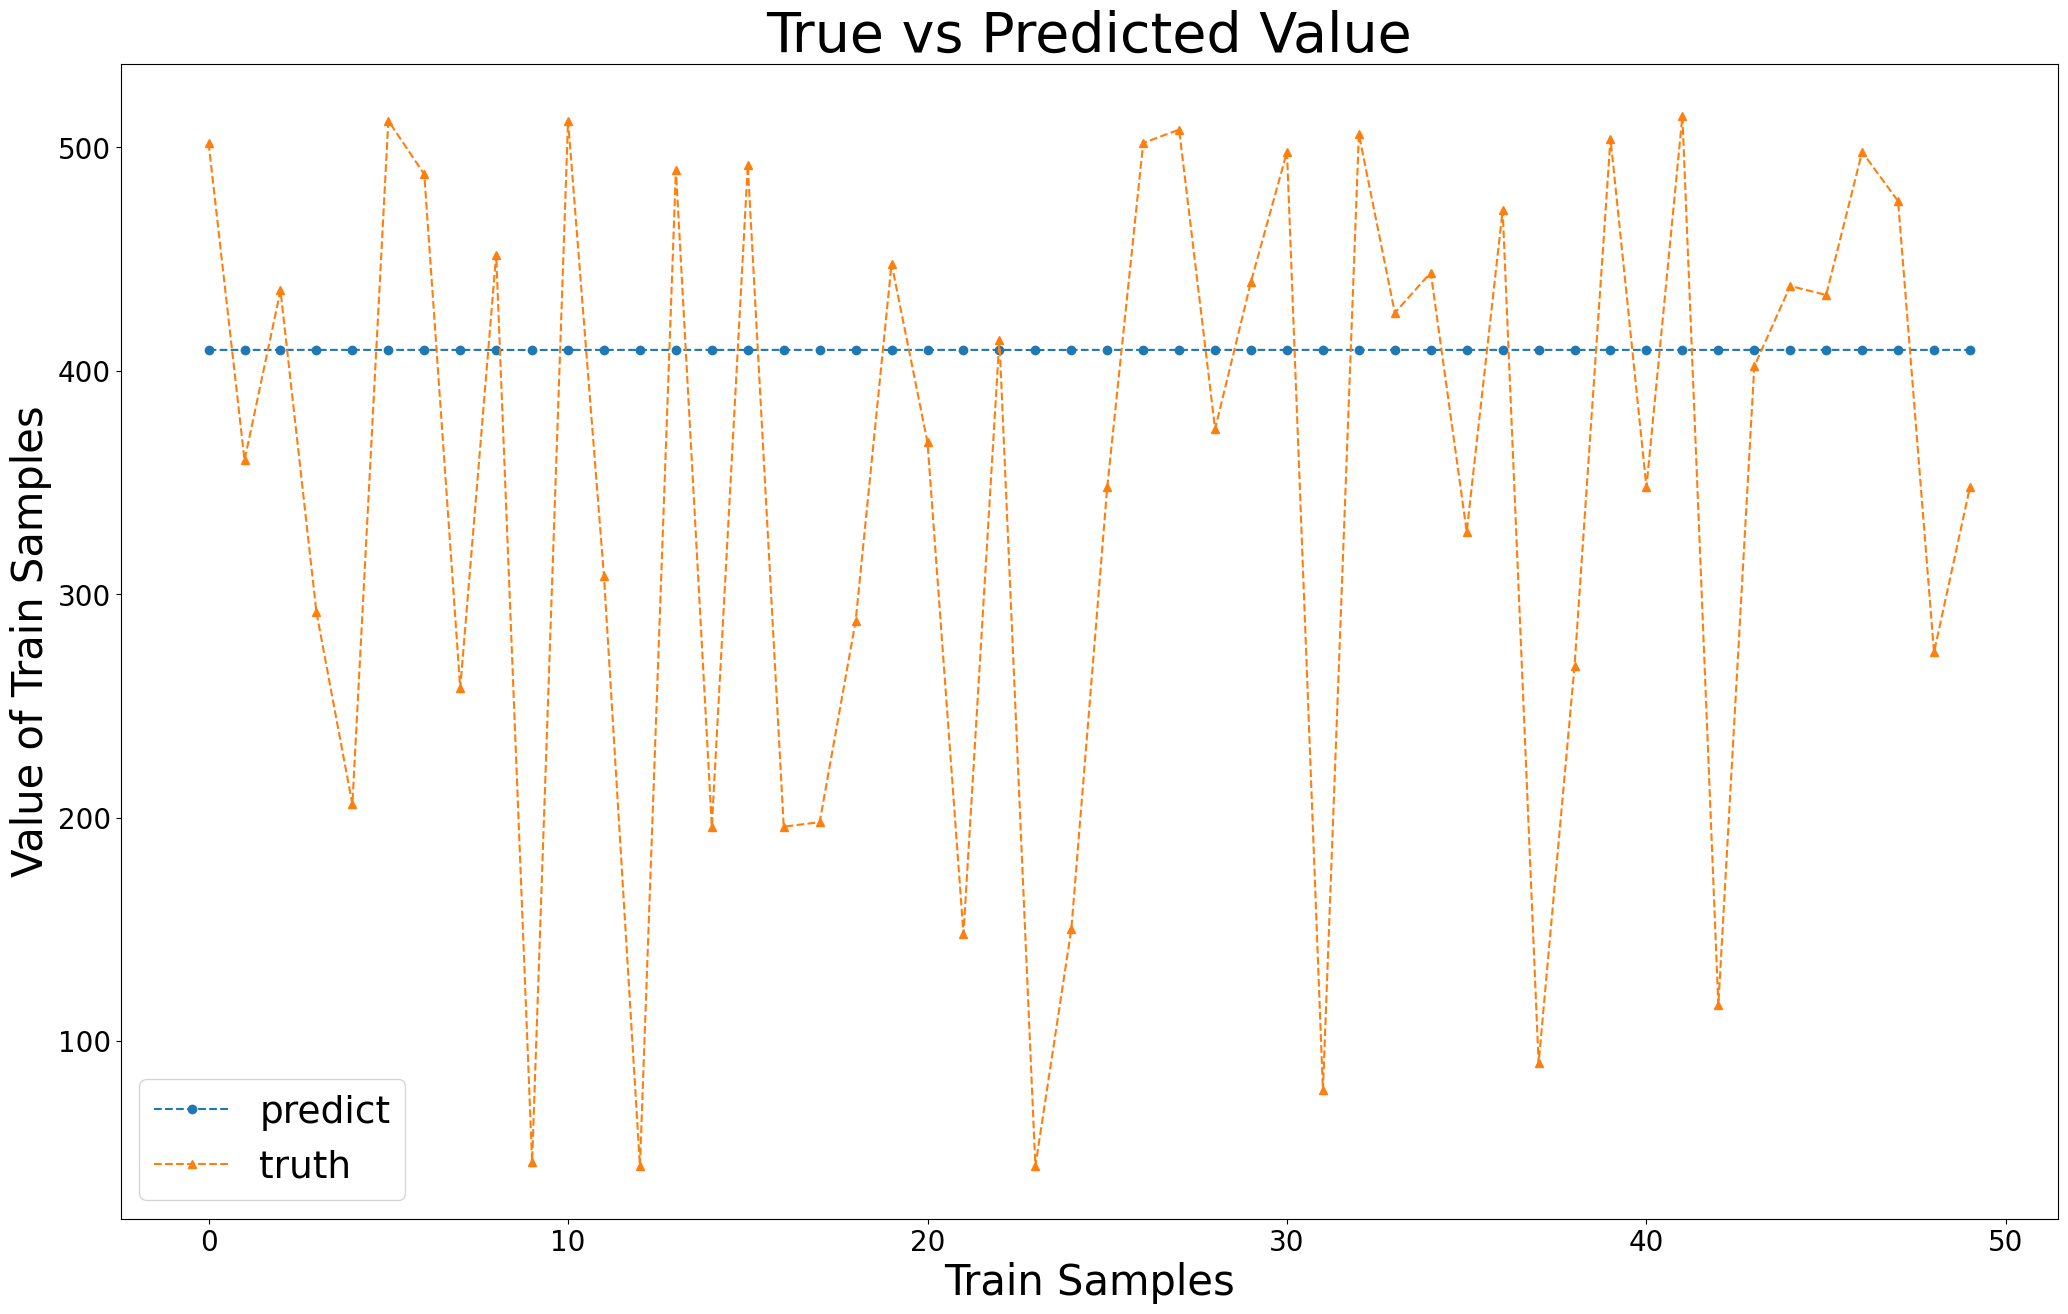

In [17]:
# To plot the value of some of the training data after training and compare them to the real values

import matplotlib.pyplot as plt

x = range(X_train[0: 50].shape[0])
y1 = vf(X_train[0: 50]).squeeze().tolist()
y2 = y_train[0: 50].squeeze().tolist()

plt.figure(figsize=(25, 15))

plt.title('True vs Predicted Value', fontdict={'size': 40})
plt.xlabel('Train Samples', fontdict={'size': 30})
plt.ylabel('Value of Train Samples', fontdict={'size': 30})
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.plot(x, y1, 'o--', label = "predict")
plt.plot(x, y2, '^--', label = "truth")
plt.legend(loc='lower left', fontsize=27)
plt.savefig("train.pdf")
plt.show()

torch.Size([50, 1])


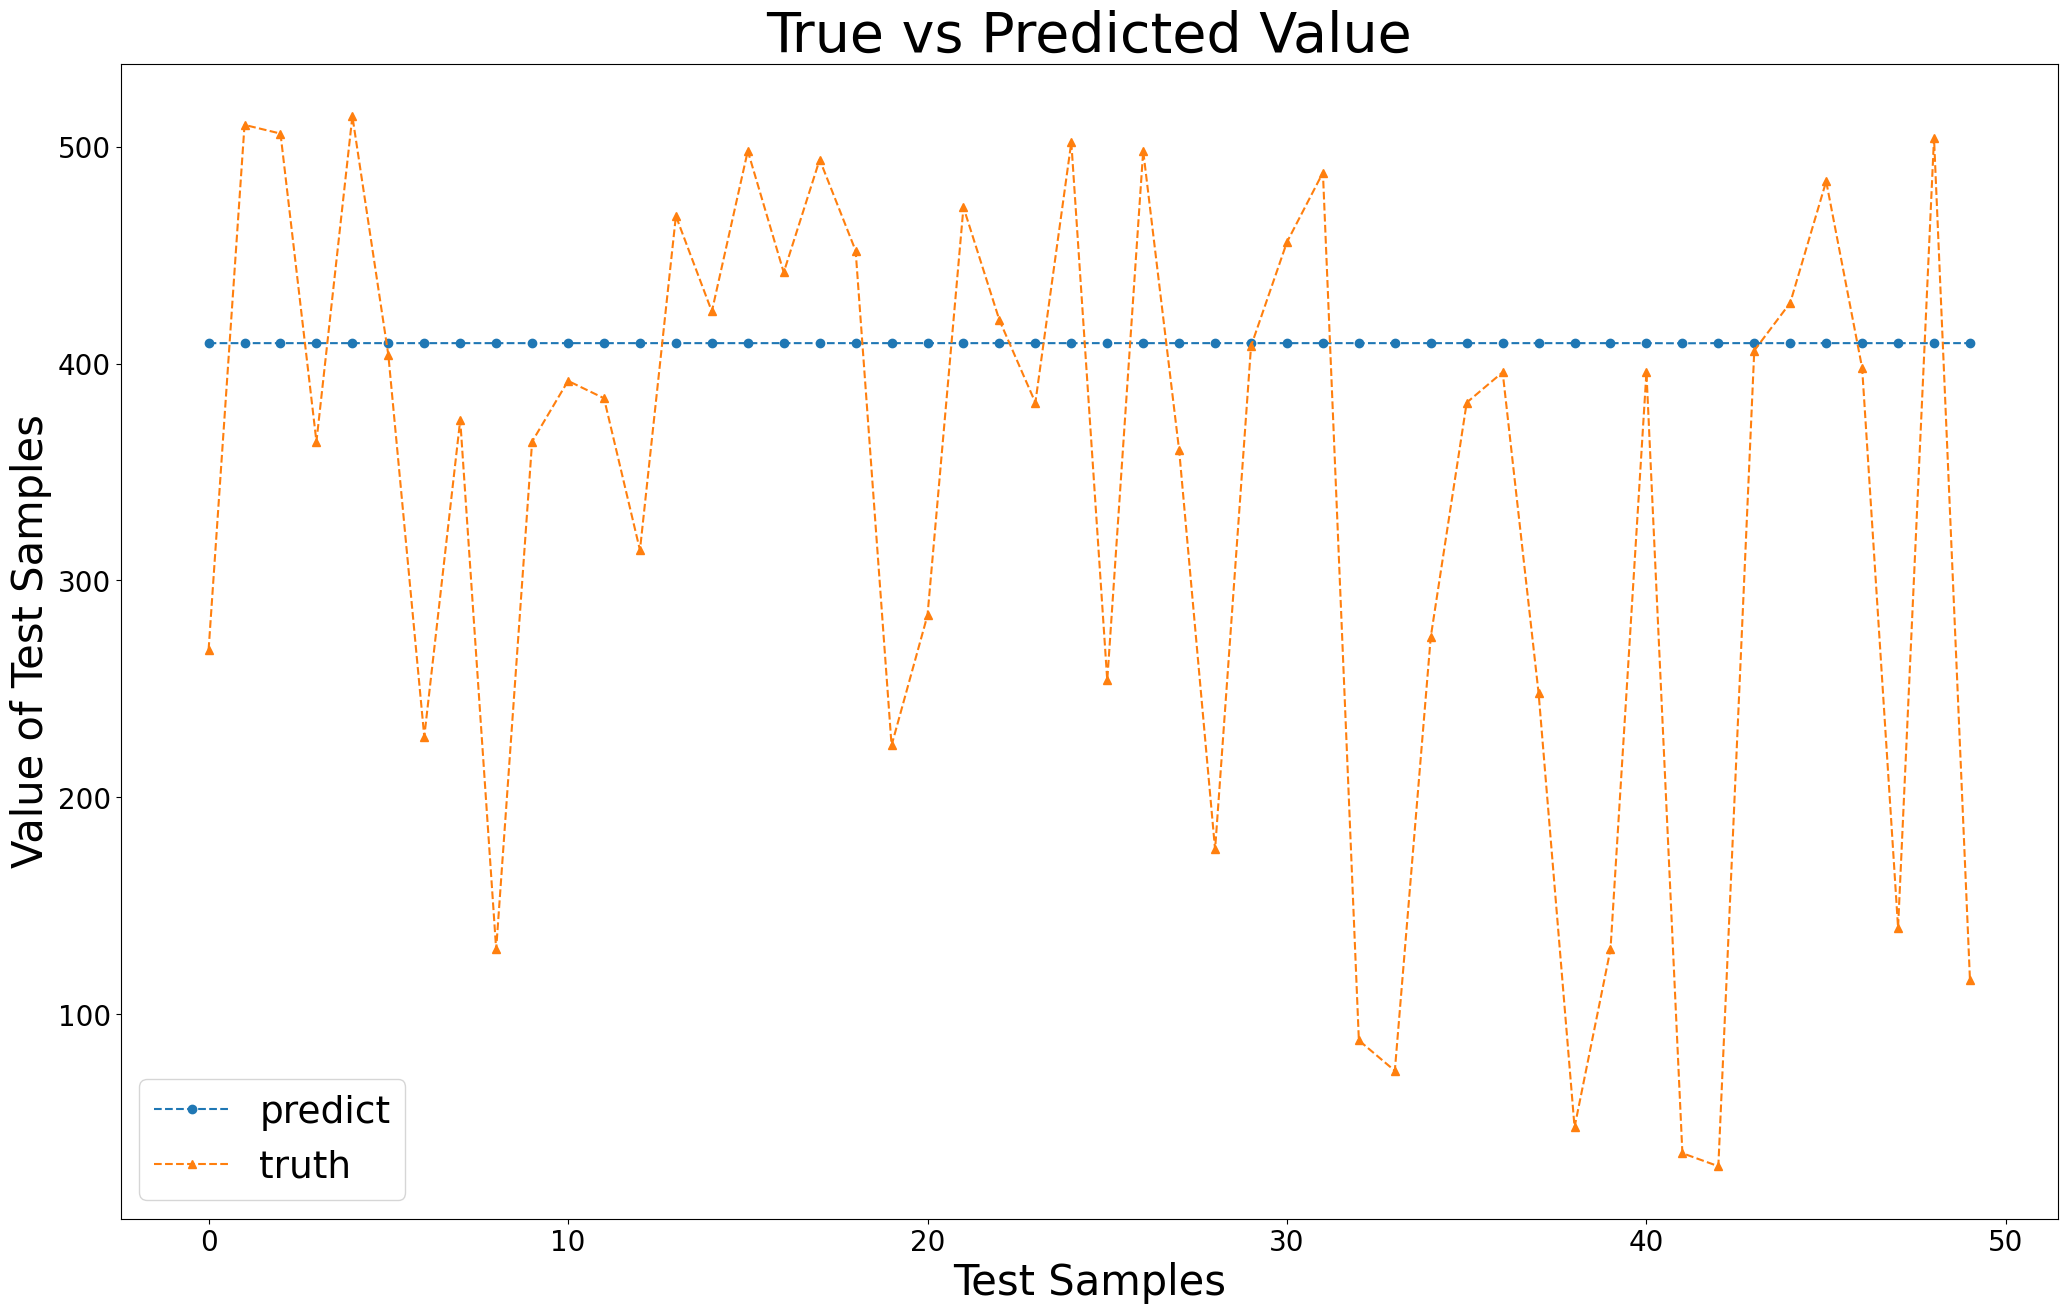

In [18]:
# To plot the value of some of the test data after training and compare them to the real values

import matplotlib.pyplot as plt

x = range(X_test[0: 50].shape[0])
y1 = vf(X_test[0: 50]).squeeze().tolist()
y2 = y_test[0: 50].tolist()
print(vf(X_test[0: 50]).size())

plt.figure(figsize=(25, 15))

plt.title('True vs Predicted Value', fontdict={'size': 40})
plt.xlabel('Test Samples', fontdict={'size': 30})
plt.ylabel('Value of Test Samples', fontdict={'size': 30})
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.plot(x, y1, 'o--', label = "predict")
plt.plot(x, y2, '^--', label = "truth")
plt.legend(loc='lower left', fontsize=27)
plt.savefig("test.pdf")
plt.show()

### Multiple Running

In [5]:
from comblearn.data import ExtendedDSFValueFunction, DSFValueFunction, DeepSets, SetTransformer
from torch.optim import Adam
from torch import nn

def trial(no, tr_losses):
    print(f"Trial {no}:")

    auction = CombinatorialAuction(cfg['auction'])
    if config['prob'] == 'low':
        X, y = auction.data_handler.R['0']
    elif config['prob'] == 'mid':
        X, y = auction.data_handler.R['1']
    else:
        X, y = auction.data_handler.R['2']
    items = auction.items

    n = X.shape[0]
    tr = int(80/100 * n)
    X_train = X[0: tr]
    y_train = y[0: tr] 
    X_test = X[tr:]
    y_test = y[tr:]

    for vfc in vf_configs:
        print(f'Config {vfc}:')
        if vfc == 'edsf':
            vf = ExtendedDSFValueFunction(items, 60, [64, 64, 64, 64], 95).to("cuda")
        elif vfc == 'dpst':
            vf = DeepSets(items, [512, 512, 512, 512], [512, 512, 512, 512]).to('cuda')
        elif vfc == 'dsf':
            vf = DSFValueFunction(items, 60, [64, 64, 64], 95).to("cuda")
        elif vfc == 'strf':
            vf = SetTransformer(items, num_outputs=1, dim_output=1, dim_hidden=64).to("cuda")

        optimizer = Adam(vf.parameters(), lr=0.01)
        criterion = nn.L1Loss()

        losses = []

        for _ in range(5000):
            optimizer.zero_grad()
            yp = vf(X_train)
            loss = criterion(yp, y_train)
            loss.backward(retain_graph=True)
            losses.append(loss.item())
            optimizer.step()
            with torch.no_grad():
                vf.relu()
            if _ % 1000 == 0:
                print(loss)
        train_loss = loss

        yp = vf(X_test)
        test_loss = criterion(yp, y_test)

        print(f'Train, Test loss: {[train_loss.item(), test_loss.item()]}')
        tr_losses[vfc].append([train_loss.item(), test_loss.item()])
    

In [6]:
trial_losses = {'edsf': [], 'dsf': [], 'dpst': [], 'strf': []}

### Cut Results

In [7]:
for _ in range(20):
    trial(_, trial_losses)

Trial 0:


Config edsf:
tensor(86.1363, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.6781, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.3728, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(3.5875, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.1192, device='cuda:0', grad_fn=<MeanBackward0>)
Train, Test loss: [4.491467475891113, 4.492280006408691]
Config dsf:
tensor(163.1979, device='cuda:0', grad_fn=<MeanBackward0>)


/home/mohammad_hosseini/anaconda3/envs/auction/lib/python3.10/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([819])) that is different to the input size (torch.Size([819, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


tensor(110.7497, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(110.7459, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(110.7454, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(110.7466, device='cuda:0', grad_fn=<MeanBackward0>)


/home/mohammad_hosseini/anaconda3/envs/auction/lib/python3.10/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([205])) that is different to the input size (torch.Size([205, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Train, Test loss: [110.7954330444336, 112.60953521728516]
Config dpst:
tensor(314.6984, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(110.7529, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(110.7535, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(111.0600, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(110.7458, device='cuda:0', grad_fn=<MeanBackward0>)
Train, Test loss: [110.74559783935547, 112.42704010009766]
Config strf:
tensor(314.7885, device='cuda:0', grad_fn=<MeanBackward0>)


/home/mohammad_hosseini/anaconda3/envs/auction/lib/python3.10/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([819])) that is different to the input size (torch.Size([819, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


tensor(110.7472, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(110.7477, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(147219.3125, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1380.5427, device='cuda:0', grad_fn=<MeanBackward0>)


/home/mohammad_hosseini/anaconda3/envs/auction/lib/python3.10/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([205])) that is different to the input size (torch.Size([205, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Train, Test loss: [459.4245300292969, 1505.87060546875]
Trial 1:
Config edsf:
tensor(83.1289, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.6782, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(3.9059, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(3.5768, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.2116, device='cuda:0', grad_fn=<MeanBackward0>)
Train, Test loss: [4.379246711730957, 4.331000804901123]
Config dsf:
tensor(166.2322, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(111.8949, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(111.8999, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(111.9004, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(111.9015, device='cuda:0', grad_fn=<MeanBackward0>)
Train, Test loss: [111.90398406982422, 108.78186798095703]
Config dpst:
tensor(320.2892, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(111.9084, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(111.8999, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(111.8923, device

In [8]:
import numpy as np

for vfc in vf_configs:
    print(f"Config {vfc}:", np.mean(trial_losses[vfc], axis=0), np.std(trial_losses[vfc], axis=0))

Config edsf: [4.76830152 4.91213013] [0.7200427  0.70460598]
Config dsf: [121.31919823 121.30953789] [6.18783743 9.85309557]
Config dpst: [121.35225677 121.12341232] [6.19133938 9.88893157]
Config strf: [ 4834006.09720116 37812866.30892525] [2.10176429e+07 1.64768335e+08]


In [14]:
a = np.array(trial_losses['strf'])
x = a[a[:, 0] < 450]
x

array([[120.53309631, 129.85771179],
       [337.0668335 , 486.35168457],
       [119.56211853, 134.33317566],
       [115.5067215 , 111.58563232],
       [124.81218719, 116.52788544],
       [113.55007935, 104.54685211],
       [125.30612183, 124.90061188],
       [118.4329071 , 121.87302399],
       [127.96892548, 128.95684814],
       [123.4294281 , 119.5026474 ]])

In [15]:
np.mean(x, axis=0), np.std(x, axis=0)

(array([142.61684189, 157.84360733]), array([ 64.95698146, 109.82915764]))

### Coverage Results

In [ ]:
for _ in range(17):
    trial(_, trial_losses)

Trial 0:
Config edsf:
tensor(199.3062, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.5174, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.7493, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.4466, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.5988, device='cuda:0', grad_fn=<MeanBackward0>)
Train, Test loss: [1.1347380876541138, 1.3079599142074585]
Config dsf:
tensor(41.8976, device='cuda:0', grad_fn=<MeanBackward0>)


/home/mohammad_hosseini/anaconda3/envs/auction/lib/python3.10/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([819])) that is different to the input size (torch.Size([819, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


tensor(33.3120, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(33.3390, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(33.3121, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(33.3201, device='cuda:0', grad_fn=<MeanBackward0>)


/home/mohammad_hosseini/anaconda3/envs/auction/lib/python3.10/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([205])) that is different to the input size (torch.Size([205, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Train, Test loss: [33.31831741333008, 33.12947463989258]
Config dpst:
tensor(72.7038, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(18.1594, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(18.2445, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(18.1017, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(18.1908, device='cuda:0', grad_fn=<MeanBackward0>)
Train, Test loss: [18.097858428955078, 17.28314781188965]
Config strf:
tensor(72.5504, device='cuda:0', grad_fn=<MeanBackward0>)


/home/mohammad_hosseini/anaconda3/envs/auction/lib/python3.10/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([819])) that is different to the input size (torch.Size([819, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


tensor(18.1432, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(18.1667, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(18.1030, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(18.0915, device='cuda:0', grad_fn=<MeanBackward0>)


/home/mohammad_hosseini/anaconda3/envs/auction/lib/python3.10/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([205])) that is different to the input size (torch.Size([205, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Train, Test loss: [18.10145378112793, 17.268917083740234]
Trial 1:
Config edsf:
tensor(196.5285, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.9322, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.3650, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.3478, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.1642, device='cuda:0', grad_fn=<MeanBackward0>)
Train, Test loss: [1.360821008682251, 1.2894835472106934]
Config dsf:
tensor(49.8016, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(34.9262, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(34.9264, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(34.9291, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(34.9274, device='cuda:0', grad_fn=<MeanBackward0>)
Train, Test loss: [34.92683792114258, 35.249176025390625]
Config dpst:
tensor(74.6492, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(18.5290, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(18.5281, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(18.5306, device='cuda

In [ ]:
import numpy as np

for vfc in vf_configs:
    print(f"Config {vfc}:", np.mean(trial_losses[vfc], axis=0), np.std(trial_losses[vfc], axis=0))

In [ ]:
trial_losses['edsf']

[[1.5418729782104492, 1.5546791553497314],
 [1.107243299484253, 0.9493502974510193],
 [1.4345685243606567, 1.6085742712020874],
 [1.1347380876541138, 1.3079599142074585],
 [1.360821008682251, 1.2894835472106934],
 [1.165985345840454, 1.3860275745391846],
 [1.3446556329727173, 1.4619309902191162],
 [1.1773674488067627, 1.3068960905075073],
 [1.2814075946807861, 1.3963677883148193],
 [1.2751438617706299, 1.2570538520812988],
 [1.074514389038086, 1.2372746467590332],
 [1.0325897932052612, 1.3663359880447388],
 [1.1993718147277832, 1.1333894729614258],
 [1.517046570777893, 1.8669912815093994],
 [1.1800575256347656, 1.272638201713562],
 [1.0645183324813843, 1.207823634147644],
 [1.1289856433868408, 1.238020420074463],
 [1.01812744140625, 1.2834986448287964],
 [1.2162352800369263, 1.1927027702331543],
 [1.5324379205703735, 1.5585013628005981]]

In [ ]:
a = np.array(trial_losses['strf'])
x = a[a[:, 0] < 2500]
x

array([[  17.19695282,   15.3431139 ],
       [1953.65625   , 1904.6262207 ],
       [  17.33520317,   19.15491867],
       [  18.10145378,   17.26891708],
       [  18.54021072,   18.50261307],
       [  18.07170868,   16.15049362],
       [  19.38231277,   17.01503754],
       [  18.08211327,   18.58819962],
       [  17.99029541,   19.41206932],
       [1647.31323242, 1392.25366211],
       [2086.56982422, 2766.12109375],
       [  17.84561729,   17.43131447],
       [  17.46702957,   16.31174469],
       [  18.48737144,   18.6121788 ]])

In [12]:
x = np.array([[  17.19695282,   15.3431139 ],
       [  17.33520317,   19.15491867],
       [  18.10145378,   17.26891708],
       [  18.54021072,   18.50261307],
       [  18.07170868,   16.15049362],
       [  19.38231277,   17.01503754],
       [  18.08211327,   18.58819962],
       [  17.99029541,   19.41206932],
       [  17.84561729,   17.43131447],
       [  17.46702957,   16.31174469],
       [  18.48737144,   18.6121788 ]])

In [13]:
np.mean(x, axis=0), np.std(x, axis=0)

(array([18.04547899, 17.61732734]), array([0.59040805, 1.27380163]))

## 2. Maximizing Social Welfare

### Config

In [3]:
config = {
    'function': 'comp' # ['dsf', 'edsf', 'vnn', 'comp', 'comp_dsf']
}

In [4]:
import yaml 

if config['function'] == 'edsf':
    with open("config_edsf_social_welfare.yaml") as fp:
        cfg = yaml.load(fp, Loader=yaml.FullLoader)
elif config['function'] == 'vnn':
    with open("config_vnn_social_welfare.yaml") as fp:
        cfg = yaml.load(fp, Loader=yaml.FullLoader)
elif config['function'] == 'comp':
    with open("config_comp_social_welfare.yaml") as fp:
        cfg = yaml.load(fp, Loader=yaml.FullLoader)
elif config['function'] == 'comp_dsf':
    with open("config_dsf_comp_social_welfare.yaml") as fp:
        cfg = yaml.load(fp, Loader=yaml.FullLoader)
else: 
    with open("config_dsf_social_welfare.yaml") as fp:
        cfg = yaml.load(fp, Loader=yaml.FullLoader)

In [5]:
device = "cuda"

def social_welfare(ws, allocation):
    return torch.sum(torch.tensor([w(alloc) for w, alloc in zip(ws, allocation)]).to(device))

In [6]:
auction = CombinatorialAuction(cfg['auction'])

social welfare is: 1577.0, iteration is: 1000
social welfare is: 2114.0, iteration is: 2000
social welfare is: 2243.0, iteration is: 3000
social welfare is: 2149.0, iteration is: 4000
social welfare is: 2188.0, iteration is: 5000
social welfare is: 1982.0, iteration is: 6000
[tensor([1., 0., 0., 1., 0., 0., 1., 0.], device='cuda:0'), tensor([0., 0., 1., 0., 1., 0., 0., 1.], device='cuda:0'), tensor([0., 1., 0., 0., 0., 1., 0., 0.], device='cuda:0')]
Brute Force Search: done.
Optimal Social Welfare: 2378.0


### Randomized Greedy

In [8]:
allocation, social_welfare = auction.run()

INFO:root:Final allocation calculation...
/home/mohammad_hosseini/anaconda3/envs/auction/lib/python3.10/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([64, 1])) that is different to the input size (torch.Size([64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


KeyboardInterrupt: 

In [ ]:
social_welfare, allocation

### Gradient Ascent

In [7]:
auction.allocation_config['scheme'] = 'GradientAscent'
auction.allocation_config['optimizer'] = 'comblearn.optim.GradientAscentOptimizer'  # Change this to batch if you want to perform a batch optimization
auction.allocation_config['learning-rate'] = 0.001
auction.allocation_config['batch-size'] = 100
auction.allocation_config['eps'] = 0.00

In [9]:
allocation, social_welfare, allocation1, social_welfare1 = auction.run()
# allocation, social_welfare = auction.run()

INFO:root:Final allocation calculation...
/home/mohammad_hosseini/anaconda3/envs/auction/lib/python3.10/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([64, 1])) that is different to the input size (torch.Size([64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
INFO:root:Bidder 0, loss: 1161.365234375
INFO:root:Bidder 1, loss: 1548.721923828125
INFO:root:Bidder 2, loss: 1563.624755859375


output is: 9610.671875, iteration is: 0
output is: 9611.302734375, iteration is: 1000
output is: 6942.326171875, iteration is: 2000
output is: 6942.326171875, iteration is: 3000
output is: 6942.326171875, iteration is: 4000


INFO:root:Compare to other models...


Final Distribution: tensor([[0.0000, 0.9092, 0.0908],
        [0.0000, 0.4474, 0.5526],
        [0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 1.0000],
        [0.0000, 0.5458, 0.4542],
        [0.0000, 0.0000, 1.0000],
        [0.0000, 0.2918, 0.7082],
        [0.0000, 0.4387, 0.5613]], device='cuda:0', requires_grad=True)


INFO:root:Bidder 0, loss: 101.3314437866211
INFO:root:Bidder 1, loss: 42.726383209228516
INFO:root:Bidder 2, loss: 13.911704063415527


output is: 6528.98828125, iteration is: 0
output is: 7393.84912109375, iteration is: 1000
output is: 7393.84912109375, iteration is: 2000
output is: 7393.84912109375, iteration is: 3000
output is: 7393.84912109375, iteration is: 4000
Final Distribution: tensor([[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.]], device='cuda:0', requires_grad=True)


In [10]:
allocation, social_welfare, allocation1, social_welfare1

({'0': tensor([0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0'),
  '1': tensor([1., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0'),
  '2': tensor([0., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')},
 tensor([7090.2241], device='cuda:0', grad_fn=<AddBackward0>),
 {'0': tensor([0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0'),
  '1': tensor([1., 1., 1., 0., 1., 1., 0., 0.], device='cuda:0'),
  '2': tensor([0., 0., 0., 1., 0., 0., 1., 1.], device='cuda:0')},
 tensor([7426.2471], device='cuda:0', grad_fn=<AddBackward0>))

In [10]:
from comblearn.env import BruteForceOptimizer


ws = [b.vf for b in auction.bidders]

optim_aux = BruteForceOptimizer(len(auction.items), len(auction.bidders), ws)
opt_alloc = optim_aux.optimize()
opt_sw = optim_aux._social_welfare(opt_alloc)

opt_sw

social welfare is: 1094.0, iteration is: 1000
social welfare is: 1525.0, iteration is: 2000
social welfare is: 1513.0, iteration is: 3000
social welfare is: 1544.0, iteration is: 4000
social welfare is: 1695.0, iteration is: 5000
social welfare is: 1507.0, iteration is: 6000
[tensor([0., 0., 0., 1., 0., 0., 0., 0.], device='cuda:0'), tensor([0., 1., 1., 0., 1., 1., 0., 0.], device='cuda:0'), tensor([1., 0., 0., 0., 0., 0., 1., 1.], device='cuda:0')]


tensor(1771.)

In [9]:
social_welfare / 96#, social_welfare1 / 96

tensor(0.8021, device='cuda:0')

In [ ]:
allocation1, social_welfare1

In [ ]:
print(f'optimal social welfare for auction with coverage value funciton is: {social_welfare}')
print(f'final allocation for auction with coverage value functions is: {allocation}')

IF you wanna run the auction for a desired number of times (here 10), and compare the ouptut of gradient ascent to the optimal ouput (result of brute force).

In [15]:
from comblearn.env import BruteForceOptimizer

output = []
for i in range(3):
    auction = CombinatorialAuction(cfg['auction'])
    optimal_social_welfare = auction.data_handler.opt_sw
    # _, rg_social_welfare = auction.run()
    auction.allocation_config['scheme'] = 'GradientAscent'
    auction.allocation_config['optimizer'] = 'comblearn.optim.GradientAscentOptimizer'  # Change this to batch if you want to perform a batch optimization
    auction.allocation_config['learning-rate'] = 0.001
    auction.allocation_config['batch-size'] = 100
    auction.allocation_config['eps'] = 0.00
    _, social_welfare, _,  social_welfare1 = auction.run()
    ws = [b.vf for b in auction.bidders]

    optim_aux = BruteForceOptimizer(len(auction.items), len(auction.bidders), ws)
    opt_alloc = optim_aux.optimize()
    opt_learn_sw = optim_aux._social_welfare(opt_alloc)

    output.append((social_welfare, social_welfare1, opt_learn_sw, optimal_social_welfare))

    print('A:', (social_welfare, social_welfare1, opt_learn_sw, optimal_social_welfare))

social welfare is: 1572.0, iteration is: 1000
social welfare is: 2101.0, iteration is: 2000
social welfare is: 2280.0, iteration is: 3000
social welfare is: 2134.0, iteration is: 4000
social welfare is: 2229.0, iteration is: 5000
social welfare is: 1995.0, iteration is: 6000


INFO:root:Final allocation calculation...


[tensor([1., 0., 1., 0., 0., 0., 0., 1.], device='cuda:0'), tensor([0., 1., 0., 1., 1., 0., 0., 0.], device='cuda:0'), tensor([0., 0., 0., 0., 0., 1., 1., 0.], device='cuda:0')]
Brute Force Search: done.
Optimal Social Welfare: 2375.0


INFO:root:Bidder 0, loss: 3.356746196746826
INFO:root:Bidder 1, loss: 2.545712947845459
INFO:root:Bidder 2, loss: 7.805148124694824


output is: 2305.421875, iteration is: 0
output is: 2388.54541015625, iteration is: 1000
output is: 2388.28662109375, iteration is: 2000
output is: 2387.5419921875, iteration is: 3000
output is: 2388.248291015625, iteration is: 4000


INFO:root:Compare to other models...


Final Distribution: tensor([[0.9814, 0.0186, 0.0000],
        [0.2637, 0.6849, 0.0514],
        [0.9655, 0.0345, 0.0000],
        [0.0022, 0.9978, 0.0000],
        [0.2750, 0.0236, 0.7014],
        [0.0212, 0.0359, 0.9430],
        [0.0012, 0.9988, 0.0000],
        [0.9618, 0.0382, 0.0000]], device='cuda:0', requires_grad=True)


INFO:root:Bidder 0, loss: 167.10012817382812
INFO:root:Bidder 1, loss: 113.24809265136719
INFO:root:Bidder 2, loss: 36.23309326171875


output is: 2550.953857421875, iteration is: 0
output is: 2550.953857421875, iteration is: 1000
output is: 2550.953857421875, iteration is: 2000
output is: 2550.953857421875, iteration is: 3000
output is: 2550.953857421875, iteration is: 4000
Final Distribution: tensor([[0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333]], device='cuda:0', requires_grad=True)
social welfare is: 1572.0, iteration is: 1000
social welfare is: 2101.0, iteration is: 2000
social welfare is: 2280.0, iteration is: 3000
social welfare is: 2134.0, iteration is: 4000
social welfare is: 2229.0, iteration is: 5000
social welfare is: 1995.0, iteration is: 6000
[tensor([1., 0., 1., 0., 0., 0., 0., 1.], device='cuda:0'), tensor([0., 1., 0., 1., 1., 0., 0., 0.], device='cuda:0'), tensor([0., 0., 0., 0., 0., 1., 1

INFO:root:Final allocation calculation...


[tensor([0., 0., 1., 1., 0., 0., 0., 1.], device='cuda:0'), tensor([1., 1., 0., 0., 0., 0., 1., 0.], device='cuda:0'), tensor([0., 0., 0., 0., 1., 1., 0., 0.], device='cuda:0')]
Brute Force Search: done.
Optimal Social Welfare: 2382.0


INFO:root:Bidder 0, loss: 5.252577304840088
INFO:root:Bidder 1, loss: 6.952197074890137
INFO:root:Bidder 2, loss: 16.140228271484375


output is: 2275.4951171875, iteration is: 0
output is: 2397.22314453125, iteration is: 1000
output is: 2393.85400390625, iteration is: 2000
output is: 2395.395751953125, iteration is: 3000
output is: 2361.14111328125, iteration is: 4000


INFO:root:Compare to other models...


Final Distribution: tensor([[5.4270e-04, 7.6515e-02, 9.2294e-01],
        [9.5560e-01, 4.4398e-02, 0.0000e+00],
        [3.0829e-01, 6.9171e-01, 0.0000e+00],
        [9.1066e-01, 8.9340e-02, 0.0000e+00],
        [1.3989e-03, 9.9860e-01, 0.0000e+00],
        [5.8332e-01, 3.4550e-02, 3.8213e-01],
        [0.0000e+00, 1.0000e+00, 0.0000e+00],
        [9.5734e-01, 4.2655e-02, 0.0000e+00]], device='cuda:0',
       requires_grad=True)


INFO:root:Bidder 0, loss: 159.609375
INFO:root:Bidder 1, loss: 112.22251892089844
INFO:root:Bidder 2, loss: 39.5081787109375


output is: 2546.722900390625, iteration is: 0
output is: 2546.722900390625, iteration is: 1000
output is: 2546.722900390625, iteration is: 2000
output is: 2546.722900390625, iteration is: 3000
output is: 2546.722900390625, iteration is: 4000
Final Distribution: tensor([[0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333]], device='cuda:0', requires_grad=True)
social welfare is: 1567.0, iteration is: 1000
social welfare is: 2078.0, iteration is: 2000
social welfare is: 2299.0, iteration is: 3000
social welfare is: 2158.0, iteration is: 4000
social welfare is: 2268.0, iteration is: 5000
social welfare is: 2018.0, iteration is: 6000
[tensor([0., 0., 1., 1., 0., 0., 0., 1.], device='cuda:0'), tensor([1., 1., 0., 0., 0., 0., 1., 0.], device='cuda:0'), tensor([0., 0., 0., 0., 1., 1., 0

INFO:root:Final allocation calculation...


[tensor([0., 0., 1., 0., 0., 1., 1., 0.], device='cuda:0'), tensor([0., 1., 0., 1., 1., 0., 0., 0.], device='cuda:0'), tensor([1., 0., 0., 0., 0., 0., 0., 1.], device='cuda:0')]
Brute Force Search: done.
Optimal Social Welfare: 2379.0


INFO:root:Bidder 0, loss: 4.039487838745117
INFO:root:Bidder 1, loss: 1.9308342933654785
INFO:root:Bidder 2, loss: 17.16421890258789


output is: 2308.75390625, iteration is: 0
output is: 2410.962158203125, iteration is: 1000
output is: 2411.19482421875, iteration is: 2000
output is: 2411.74267578125, iteration is: 3000
output is: 2411.6865234375, iteration is: 4000


INFO:root:Compare to other models...


Final Distribution: tensor([[0.0164, 0.0366, 0.9470],
        [0.0000, 1.0000, 0.0000],
        [0.9753, 0.0247, 0.0000],
        [0.0023, 0.9977, 0.0000],
        [0.2452, 0.7548, 0.0000],
        [0.9727, 0.0273, 0.0000],
        [0.2867, 0.0425, 0.6708],
        [0.9708, 0.0292, 0.0000]], device='cuda:0', requires_grad=True)


INFO:root:Bidder 0, loss: 142.65625
INFO:root:Bidder 1, loss: 82.296875
INFO:root:Bidder 2, loss: 19.29931640625


output is: 2597.0556640625, iteration is: 0
output is: 2597.33056640625, iteration is: 1000
output is: 2597.33056640625, iteration is: 2000
output is: 2597.33056640625, iteration is: 3000
output is: 2597.33056640625, iteration is: 4000
Final Distribution: tensor([[0.3538, 0.3231, 0.3231],
        [0.3538, 0.3231, 0.3231],
        [0.3471, 0.3265, 0.3265],
        [0.3455, 0.3273, 0.3273],
        [0.3570, 0.3215, 0.3215],
        [0.3493, 0.3253, 0.3253],
        [0.3466, 0.3267, 0.3267],
        [0.3503, 0.3248, 0.3248]], device='cuda:0', requires_grad=True)
social welfare is: 1557.0, iteration is: 1000
social welfare is: 2073.0, iteration is: 2000
social welfare is: 2304.0, iteration is: 3000
social welfare is: 2176.0, iteration is: 4000
social welfare is: 2223.0, iteration is: 5000
social welfare is: 2002.0, iteration is: 6000
[tensor([0., 0., 1., 0., 0., 1., 1., 0.], device='cuda:0'), tensor([0., 1., 0., 1., 1., 0., 0., 0.], device='cuda:0'), tensor([1., 0., 0., 0., 0., 0., 0., 1.]

In [16]:
output

[(tensor(2277., device='cuda:0'),
  tensor(2135., device='cuda:0'),
  tensor(2375.),
  tensor(2375.)),
 (tensor(2347., device='cuda:0'),
  tensor(1856., device='cuda:0'),
  tensor(2382.),
  tensor(2382.)),
 (tensor(2370., device='cuda:0'),
  tensor(2231., device='cuda:0'),
  tensor(2379.),
  tensor(2379.))]

In [17]:
os += [(a.item(), b.item(), c.item(), d.item()) for a, b, c, d in output]

In [20]:
os

[(2230.0, 2204.0, 2350.0, 2350.0),
 (2371.0, 1473.0, 2392.0, 2392.0),
 (2354.0, 2089.0, 2381.0, 2381.0),
 (2277.0, 2135.0, 2375.0, 2375.0),
 (2347.0, 1856.0, 2382.0, 2382.0),
 (2370.0, 2231.0, 2379.0, 2379.0)]

In [26]:
for i in range(6):
    print(f"{i+1}& {os[i][0]}&{os[i][1]} & {os[i][2]} & {os[i][3]} & {round(100 * os[i][0]/os[i][3],2)} & {round(100 * os[i][1]/os[i][3], 2)} \\\\")

1& 2230.0&2204.0 & 2350.0 & 2350.0 & 94.89 & 93.79 \\
2& 2371.0&1473.0 & 2392.0 & 2392.0 & 99.12 & 61.58 \\
3& 2354.0&2089.0 & 2381.0 & 2381.0 & 98.87 & 87.74 \\
4& 2277.0&2135.0 & 2375.0 & 2375.0 & 95.87 & 89.89 \\
5& 2347.0&1856.0 & 2382.0 & 2382.0 & 98.53 & 77.92 \\
6& 2370.0&2231.0 & 2379.0 & 2379.0 & 99.62 & 93.78 \\


In [ ]:
import numpy as np

print(f"Avg & {np.mean([x[0] for x in os])} & {np.mean([x[1] for x in os])} & {np.mean([x[2] for x in os])} & {np.mean([x[3] for x in os])} &{np.mean([round(100* x[0]/x[2]) for x in os])} &{np.mean([round(100* x[1]/x[2]) for x in os])}")

In [ ]:
gas = [a.item() for _, a, _ in output]
rgs = [a.item() for a, _, _ in output]

In [ ]:
import numpy as np

list(zip(rgs, gas))

In [ ]:
np.mean(gas), np.mean(rgs)

In [ ]:
s = 0
k = 0
print("Trial No,Predicted, Optimal, Efficiency")
for x,y in output:
    k += 1
    print(f"{k},\t{x.item()},\t{y.item()},\t{x.item() / y.item()}")
    s += x.item() / y.item()
s/15